In [1]:
import numpy as np
import pprint
from functools import lru_cache
import pandas as pd
import matplotlib.pyplot as plt
pp = pprint.PrettyPrinter(indent=4)
NUM_ROWS = 3
NUM_COLS = 4


/var/folders/rv/0pm7xkrn78b0t6cj8q0391r40000gn/T/ipykernel_24723/2548287881.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
arrs = []
cnt = 1
A = ("Up","Right","Down","Left","None")
S = [i +1 for i in range(NUM_COLS * NUM_ROWS)]
for i in range(NUM_COLS):
    arr=[]
    for j in range(NUM_ROWS):
        arr.append([cnt])
        cnt = cnt + 1
    arrs.append(np.array(arr))
grid = np.hstack(arrs)
def rc_to_s(tpl):
    return grid[tpl[0] - 1,tpl[1] - 1]

def show_layout(_arr):
    pp.pprint(np.flip(_arr.reshape(NUM_ROWS,NUM_COLS),axis=0))
def s_to_rc(val):
    for i,x in enumerate(grid):
        for j,y in enumerate(x):
            if y == val:
                return (i + 1,j + 1)
    raise RuntimeError(f"{val} Is not a valid state in s_to_rc function. Terminiating")


In [3]:
def is_terminal(val):
    terminal_states = [5,11,12]
    return val in terminal_states

In [4]:
def actions(state):
    if state in [11,12]: #Absorbing States
        return ["None"]
    if state in [5]: #Illegal State
        return ["None"]
    return ["Up","Left","Down","Right"]

In [5]:
@lru_cache
def calc_transition(s,action):
    if action not in A:
        raise RuntimeError(f"Invalid Action from state {s} (action = {action})")
    # if len(s) > 1:
    #     return calc_transition(s,action)
    if not (isinstance(s,int)):
        return np.array([calc_transition(_s,action=action) for _s in s]).reshape(-1,len(s)).T
    #IF s is terminal state return 1 at vector length and return vector
    if s == 11 or s == 12 or s == 5 or action == "None":
        P = np.zeros((NUM_ROWS,NUM_COLS))
        r,c = s_to_rc(s)
        P[r-1,c-1] = 1
        return P.flatten()

    action_to_delta = {
        "Up":(1,0),
        "Down":(-1,0),
        "Right":(0,1),
        "Left":(0,-1)
    }
    try:
        dr,dc = action_to_delta[action]
    except KeyError as e:
        raise RuntimeError(f"Invalid action mapping for action \"{action}\"")
    r,c = s_to_rc(s)

    if dr!= 0 and dc != 0:
        raise RuntimeError("You cannot not diagonally")

    P = np.zeros(shape=(NUM_ROWS,NUM_COLS))

    if dr != 0:
        new_r = r + dr
        if new_r > NUM_ROWS or new_r < 1:
            new_r = r
        if new_r == 2 and c == 2:
            new_r = r
        P[new_r -1, c -1] = 0.8
        if c < NUM_COLS and not (r == 2 and (c + 1) == 2):
            P[r - 1, c] = 0.1
        else:
            P[r-1, c -1] = P[r-1,c-1] + 0.1
        if c > 1 and not (r == 2 and (c -1) == 2):
            P[r - 1, c - 2] = 0.1
        else:
            P[r-1, c-1] = P[r-1,c-1] + 0.1

    if dc != 0:
        new_c = c  +dc
        if new_c > NUM_COLS or new_c < 1:
            new_c = c
        if r == 2 and new_c == 2:
            new_c = c
        P[r -1, new_c -1] = 0.8

        if r <NUM_ROWS and not (r+1 == 2 and c == 2):
            P[r, c-1] = 0.1
        else:
            P[r-1,c-1] = P[r-1,c-1] + 0.1
        
        if r > 1 and not (r-1 == 2 and c== 2):
            P[r-2,c-1] = 0.1
        else:
            P[r-1,c-1] = P[r-1,c-1] + 0.1
    
    return P.flatten()

show_layout(calc_transition(11,"Right")) 

array([[0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]])


In [6]:
# P_matricies = {a:calc_transition(S,a) for a in A} # Ask Dr. Hahsler on this one (Python vs r vectors causing lookup problems so i just lru cache the functions for speed)



@lru_cache
def P(sp,s,a):
    _mtx = calc_transition(s,a).reshape(NUM_ROWS,NUM_COLS)
    r,c = s_to_rc(sp)
    return _mtx[r-1, c-1]
    # pp.pprint(_mtx.reshape(NUM_ROWS,NUM_COLS))

def R(s,a,s_prime):
    if a == "None" or s == 11 or s == 12:
        return 0
    if s_prime == 12:
        return 1
    if s_prime == 11:
        return -1
    
    return(-0.04)

# print(P(5,4,"Up"))
print(R(12,"None",12))


0


In [7]:
pi_manual = ["Up"] * len(S)
pi_manual[10] = "Right"
pi_manual[9] = "Right"
pi_manual[8] = "Right"
pi_manual = np.array(pi_manual)
show_layout(pi_manual)

def generate_random_deterministic_policy():
    return np.array([np.random.choice(actions(s)) for a in grid for s in a]) #Return random action based on possible actions given some state s



pi_random = generate_random_deterministic_policy()
show_layout(pi_random)

def make_policy_soft(pi,epsilon=0.1):
    _pi = pi.reshape(NUM_ROWS,NUM_COLS)
    if not isinstance(pi,type(np.array([]))):
        raise RuntimeError("Policy is not a deterministic policy")
    mtx = []
    for s in S:
        _row = {a:epsilon / len(actions(s)) for a in actions(s)} 

        r,c = s_to_rc(s)
        # act_index = actions(s).index(_pi[r-1,c-1])
        _row[_pi[r-1,c-1]] = _row[_pi[r-1,c-1]] + (1- epsilon)
        mtx.append(_row)
    res = pd.DataFrame(mtx).fillna(0)
    res.index = [i + 1 for i in res.index]
    return res[['Up','Right','Down','Left','None']]
# pp.pprint(make_policy_soft(pi_random))

pi_test = np.array([
    ['Left','Right','Down',"Right"],
    ['Left','None','Up',"None"],
    ['Right','Left','Up',"None"],
]
)
def make_random_epsilon_policy(epsilon=0.1): #Ask Hahsler about this one

    mtx = []
    for s in S:
        _row = {a:np.random.rand() for a in actions(s)} 
        _row = {k:v/np.sum([_v for _v in _row.values()]) for k,v in _row.items()}
        mtx.append(_row)
    res = pd.DataFrame(mtx).fillna(0)
    res.index = [i + 1 for i in res.index]
    return res[['Up','Right','Down','Left','None']]
show_layout(pi_test)

array([['Right', 'Right', 'Right', 'Up'],
       ['Up', 'Up', 'Up', 'Up'],
       ['Up', 'Up', 'Up', 'Up']], dtype='<U5')
array([['Right', 'Up', 'Right', 'None'],
       ['Down', 'None', 'Up', 'None'],
       ['Down', 'Up', 'Down', 'Right']], dtype='<U5')
array([['Right', 'Left', 'Up', 'None'],
       ['Left', 'None', 'Up', 'None'],
       ['Left', 'Right', 'Down', 'Right']], dtype='<U5')


## 3.6 Expected Utility

In [8]:
GAMMA = 1

In [9]:
# show_layout(calc_transition(1,"Up"))
def sample_transition(s,a):
    tmp = calc_transition(s,a).reshape(NUM_ROWS,NUM_COLS).T.flatten()
    return np.random.choice([i + 1 for i in range(len(tmp))],p=tmp)
sample_transition(1,"Up")

4

In [10]:
val, count = np.unique([sample_transition(1,"Up") for i in range(100)],return_counts=True)
print(np.vstack([val,count]))

[[ 1  2  4]
 [10 79 11]]


In [11]:
def simulate_utility(pi,s0=1,max_t=100):
    s = s0
    U = 0
    t = 0

    while True:
        s = int(s)
        if not isinstance(pi,type(pd.DataFrame())):
            # print("Not dataframe")
            # print(pi.reshape(NUM_ROWS,NUM_COLS).T.flatten())
            a = pi.reshape(NUM_ROWS,NUM_COLS).T.flatten()[s - 1]
        else:
            a = np.random.choice(pi.columns,p=np.array(pi.loc[s]))
        
        s_prime = sample_transition(s,a)
        U = U + np.power(GAMMA,t) * R(s,a,s_prime)
        s = s_prime

        if s == 11 or s == 12 or s ==5:
            break
        t = t + 1
        if t >= max_t:
            break
    return U


In [72]:
def simulate_utilities(pi,s0=1,N=1000,max_t=100):
    return np.array([simulate_utility(pi,s0=s0,max_t=max_t) for i in range(N)])
# simulate_utility(pi_manual)

In [30]:
def plot_expected_utility(utilz):
    utilz = np.array(utilz)
    print(f'Mean of utilities: {np.mean(utilz)}')
    # counts, bins = np.histogram(utilz)
    plt.hist(utilz)

Mean of utilities: 0.7278


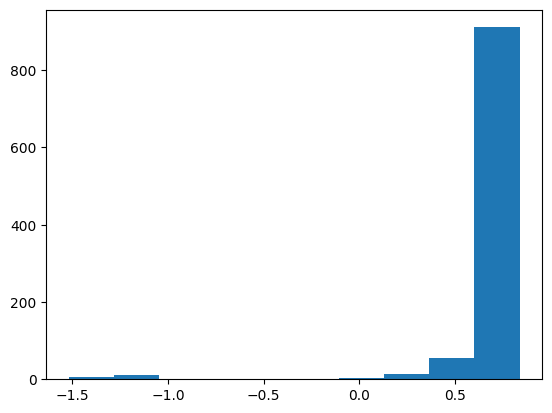

In [73]:
plot_expected_utility(simulate_utilities(pi_manual))

Mean of utilities: -3.089880000000001


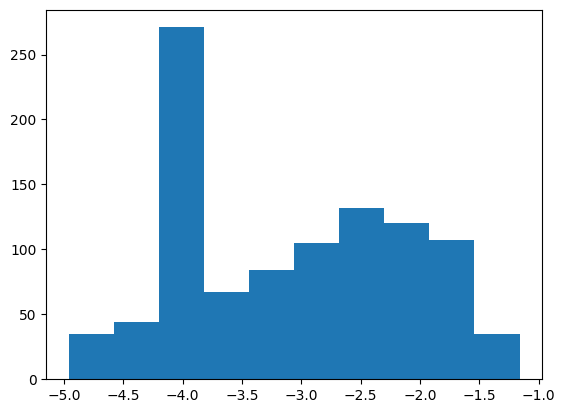

In [32]:
utility_random = np.array([simulate_utility(pi_random) for i in range(1000)])
plot_expected_utility(utility_random)

In [75]:
def get_utility_map(pi):
    # for i,x in enumerate(pi.flatten()):
    # show_layout(np.array([ i for i,x in enumerate(pi.flatten())]))
    vals = []
    for s,a in zip(grid.flatten(),pi.flatten()):
        # vals.append(f"{s}:{a}")
        vals.append(np.mean(simulate_utilities(pi,s0=s)))
    # show_layout(np.array(vals))
    return np.array(vals)


show_layout(get_utility_map(pi_manual))

array([[ 0.85536,  0.90484,  0.9648 ,  0.     ],
       [ 0.81324, -0.04   ,  0.6964 ,  0.     ],
       [ 0.7008 ,  0.39248,  0.466  , -0.83192]])


In [84]:
def argmax(x):
    y = np.where(x == np.max(x))[0]
    if len(y) > 1:
        return np.random.choice(y, 1)[0]
    else:
        return y[0]



3


In [86]:
import numpy as np

class QL_Agent:
    def __init__(self, S, A, gamma=1):
        self.S = S
        self.A = A
        self.Q = np.zeros((len(S), len(A)))
        self.N = np.zeros((len(S), len(A)), dtype=int)
        self.s = None
        self.a = 'None'
        self.gamma = gamma

    def next_episode(self):
        """Start a new episode."""
        self.s = None
        self.a = 'None'

    def reset(self):
        """Reset the agent's state and erase all persistent information."""
        # Set q-values to 0 except use NA for unavailable actions
        self.Q = np.zeros((len(self.S), len(self.A)))
        for i, s in enumerate(self.S):
            _actions = actions(s)
            for j, a in enumerate(self.A):
                if a in _actions:
                    self.Q[i, j] = 0
                else:
                    self.Q[i, j] = np.nan
        self.N = np.zeros((len(self.S), len(self.A)), dtype=int)
        self.next_episode()


# Example usage:

agent = QL_Agent(S, A)
agent.reset()
